In [2]:
import numpy as np
import tensorflow as tf
from PIL import Image
import cv2
from tqdm import tqdm, trange
from glob import glob 
import segmenteverygrain as seg
import os
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [76]:
from importlib import reload
reload(seg)

<module 'segmenteverygrain' from '/Users/zoltan/Dropbox/Segmentation/segmenteverygrain/segmenteverygrain/segmenteverygrain.py'>

## Create patches from large images

In [84]:
image_dir = '/Users/zoltan/Dropbox/Segmentation/Tiles/images/'
mask_dir = '/Users/zoltan/Dropbox/Segmentation/Tiles/labels/'
dirname = '/Users/zoltan/Dropbox/Segmentation/images/'
images = sorted(glob(dirname + "*image*"))
labels = sorted(glob(dirname + "*mask*"))

start_no = 0
for image in tqdm(images):
    # Load the large image
    large_image = tf.keras.preprocessing.image.load_img(image)
    # Convert the image to a tensor
    large_image = tf.keras.preprocessing.image.img_to_array(large_image)
    # Reshape the tensor to have a batch size of 1
    large_image = tf.reshape(large_image, [1, *large_image.shape])
    # Extract patches from the large image
    patches = tf.image.extract_patches(
        images=large_image,
        sizes=[1, 256, 256, 1],
        strides=[1, 128, 128, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )
    # Reshape the patches tensor to have a batch size of -1
    patches = tf.reshape(patches, [-1, 256, 256, 3])
    # Write patches to files
    for i in range(patches.shape[0]):
        im = np.asarray(patches[i,:,:,:]).astype('uint8')
        imname = image_dir + 'im%03d.png'%(start_no + i)
        im = Image.fromarray(im.astype(np.uint8))
        im.save(imname)
    start_no = start_no + patches.shape[0]
    
start_no = 0
for image in tqdm(labels):
    # Load the large image
    large_image = tf.keras.preprocessing.image.load_img(image)
    # Convert the image to a tensor
    large_image = tf.keras.preprocessing.image.img_to_array(large_image)
    large_image = large_image[:,:,0,np.newaxis] # only keep one layer and add a new axis
    # Reshape the tensor to have a batch size of 1
    large_image = tf.reshape(large_image, [1, *large_image.shape])
    # Extract patches from the large image
    patches = tf.image.extract_patches(
        images=large_image,
        sizes=[1, 256, 256, 1],
        strides=[1, 128, 128, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )
    # Reshape the patches tensor to have a batch size of -1
    patches = tf.reshape(patches, [-1, 256, 256, 1])
    # Write patches to files
    for i in range(patches.shape[0]):
        im = np.asarray(patches[i,:,:,0]).astype('uint8')
        imname = mask_dir + 'im%03d.png'%(start_no + i)
        im = Image.fromarray(im.astype(np.uint8))
        im.save(imname)
    start_no = start_no + patches.shape[0]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [17:49<00:00, 26.73s/it]


## Create training, validation, and test sets

In [85]:
image_dir = '/Users/zoltan/Dropbox/Segmentation/Tiles/images/'
mask_dir = '/Users/zoltan/Dropbox/Segmentation/Tiles/labels/'
image_files = sorted(glob(os.path.join(image_dir, '*.png')))
mask_files = sorted(glob(os.path.join(mask_dir, '*.png')))

batch_size = 32
shuffle_buffer_size = 1000

# split half into training
train_idx = np.random.choice(np.arange(len(image_files)), size = int(len(image_files)/2) , replace=False)
# get the rest
idx = np.setdiff1d(np.arange(len(image_files)), train_idx)
# get val files (25% of total)
val_idx = np.random.choice(idx, size = int(len(image_files)/4) , replace=False)
# get test files (25% of total)
test_idx = np.setdiff1d(val_idx, train_idx)

# create arrays of training, validation, and test files (these are filenames)
train_images = np.array(image_files)[train_idx]
val_images = np.array(image_files)[val_idx]
test_images = np.array(image_files)[test_idx]

train_masks = np.array(mask_files)[train_idx]
val_masks = np.array(mask_files)[val_idx]
test_masks = np.array(mask_files)[test_idx]

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
train_dataset = train_dataset.map(seg.load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_masks))
val_dataset = val_dataset.map(seg.load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks))
test_dataset = test_dataset.map(seg.load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

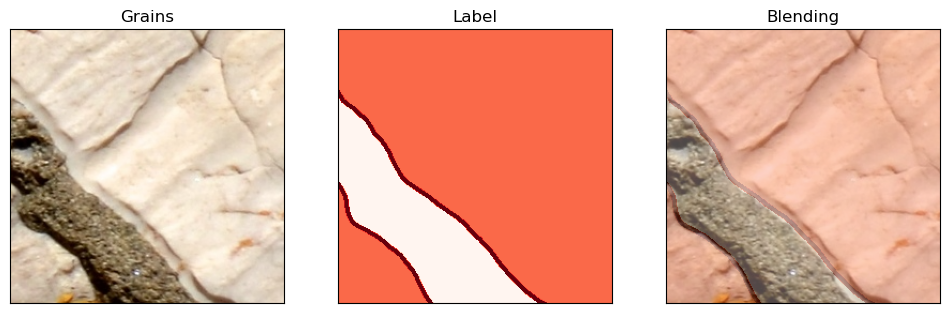

In [86]:
# check how masks look like
fname = train_images[5800]
img = cv2.imread(fname)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # need to convert from BGR to RGB
mask = cv2.imread(fname.replace('images', 'labels'))
seg.plot_images_and_labels(img, mask)

## Build, train, and evaluate model

In [87]:
model = seg.Unet()
model.compile(optimizer=Adam(), loss=seg.weighted_crossentropy, metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

 concatenate_2 (Concatenate)    (None, 128, 128, 64  0           ['conv2d_transpose_2[0][0]',     
                                )                                 'batch_normalization_1[0][0]']  
                                                                                                  
 conv2d_14 (Conv2D)             (None, 128, 128, 32  18464       ['concatenate_2[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_14[0][0]']              
                                )                                                                 
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 128, 128, 32  128        ['conv2d_15[0][0]']              
 rmalizati

In [88]:
history = model.fit(train_dataset, epochs=200, validation_data=val_dataset)

Epoch 1/200


2023-06-04 07:20:55.855086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


194/194 [==============================] - ETA: 0s - loss: 0.9343 - accuracy: 0.6866

2023-06-04 07:21:37.370260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


194/194 [==============================] - 51s 209ms/step - loss: 0.9343 - accuracy: 0.6866 - val_loss: 1.3312 - val_accuracy: 0.4969
Epoch 2/200
194/194 [==============================] - 34s 176ms/step - loss: 0.8373 - accuracy: 0.7973 - val_loss: 1.1221 - val_accuracy: 0.6776
Epoch 3/200
194/194 [==============================] - 35s 181ms/step - loss: 0.8114 - accuracy: 0.8250 - val_loss: 0.8843 - val_accuracy: 0.7584
Epoch 4/200
194/194 [==============================] - 35s 178ms/step - loss: 0.7976 - accuracy: 0.8407 - val_loss: 0.8114 - val_accuracy: 0.8260
Epoch 5/200
194/194 [==============================] - 35s 177ms/step - loss: 0.7834 - accuracy: 0.8556 - val_loss: 0.9483 - val_accuracy: 0.6363
Epoch 6/200
194/194 [==============================] - 34s 176ms/step - loss: 0.7723 - accuracy: 0.8673 - val_loss: 0.7885 - val_accuracy: 0.8673
Epoch 7/200
194/194 [==============================] - 34s 176ms/step - loss: 0.7658 - accuracy: 0.8745 - val_loss: 0.7860 - val_accurac

Epoch 57/200
194/194 [==============================] - 34s 173ms/step - loss: 0.6744 - accuracy: 0.9597 - val_loss: 0.7182 - val_accuracy: 0.9371
Epoch 58/200
194/194 [==============================] - 34s 174ms/step - loss: 0.6801 - accuracy: 0.9544 - val_loss: 0.7148 - val_accuracy: 0.9379
Epoch 59/200
194/194 [==============================] - 34s 173ms/step - loss: 0.6755 - accuracy: 0.9587 - val_loss: 0.7101 - val_accuracy: 0.9439
Epoch 60/200
194/194 [==============================] - 34s 174ms/step - loss: 0.6722 - accuracy: 0.9618 - val_loss: 0.7084 - val_accuracy: 0.9446
Epoch 61/200
194/194 [==============================] - 34s 173ms/step - loss: 0.6704 - accuracy: 0.9635 - val_loss: 0.7102 - val_accuracy: 0.9440
Epoch 62/200
194/194 [==============================] - 34s 174ms/step - loss: 0.6700 - accuracy: 0.9639 - val_loss: 0.7100 - val_accuracy: 0.9462
Epoch 63/200
194/194 [==============================] - 34s 173ms/step - loss: 0.6693 - accuracy: 0.9645 - val_loss: 0

194/194 [==============================] - 34s 172ms/step - loss: 0.6571 - accuracy: 0.9759 - val_loss: 0.7058 - val_accuracy: 0.9541
Epoch 113/200
194/194 [==============================] - 34s 172ms/step - loss: 0.6571 - accuracy: 0.9759 - val_loss: 0.7037 - val_accuracy: 0.9556
Epoch 114/200
194/194 [==============================] - 34s 173ms/step - loss: 0.6586 - accuracy: 0.9745 - val_loss: 0.7062 - val_accuracy: 0.9509
Epoch 115/200
194/194 [==============================] - 34s 172ms/step - loss: 0.6601 - accuracy: 0.9730 - val_loss: 0.7074 - val_accuracy: 0.9531
Epoch 116/200
194/194 [==============================] - 34s 172ms/step - loss: 0.6591 - accuracy: 0.9741 - val_loss: 0.7037 - val_accuracy: 0.9546
Epoch 117/200
194/194 [==============================] - 34s 172ms/step - loss: 0.6575 - accuracy: 0.9755 - val_loss: 0.7044 - val_accuracy: 0.9559
Epoch 118/200
194/194 [==============================] - 33s 171ms/step - loss: 0.6565 - accuracy: 0.9764 - val_loss: 0.7044 -

194/194 [==============================] - 34s 173ms/step - loss: 0.6527 - accuracy: 0.9800 - val_loss: 0.7047 - val_accuracy: 0.9576
Epoch 168/200
194/194 [==============================] - 34s 172ms/step - loss: 0.6526 - accuracy: 0.9801 - val_loss: 0.7026 - val_accuracy: 0.9581
Epoch 169/200
194/194 [==============================] - 34s 173ms/step - loss: 0.6523 - accuracy: 0.9803 - val_loss: 0.7047 - val_accuracy: 0.9580
Epoch 170/200
194/194 [==============================] - 34s 173ms/step - loss: 0.6521 - accuracy: 0.9806 - val_loss: 0.7028 - val_accuracy: 0.9580
Epoch 171/200
194/194 [==============================] - 34s 173ms/step - loss: 0.6524 - accuracy: 0.9803 - val_loss: 0.7042 - val_accuracy: 0.9567
Epoch 172/200
194/194 [==============================] - 34s 172ms/step - loss: 0.6526 - accuracy: 0.9801 - val_loss: 0.7044 - val_accuracy: 0.9572
Epoch 173/200
194/194 [==============================] - 34s 173ms/step - loss: 0.6523 - accuracy: 0.9804 - val_loss: 0.7044 -

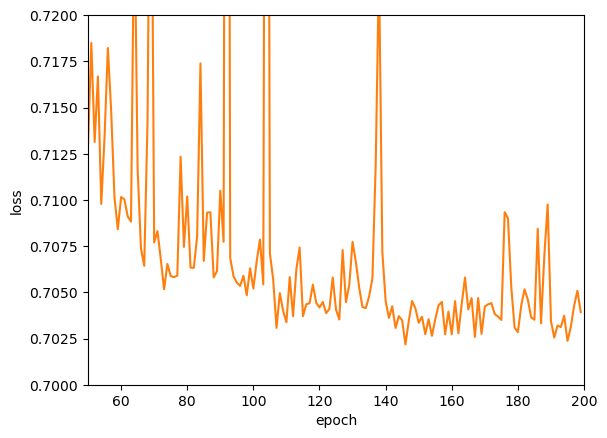

In [98]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss');
plt.xlim([50,200])
plt.ylim([0.7, 0.72]);

(0.95, 0.982)

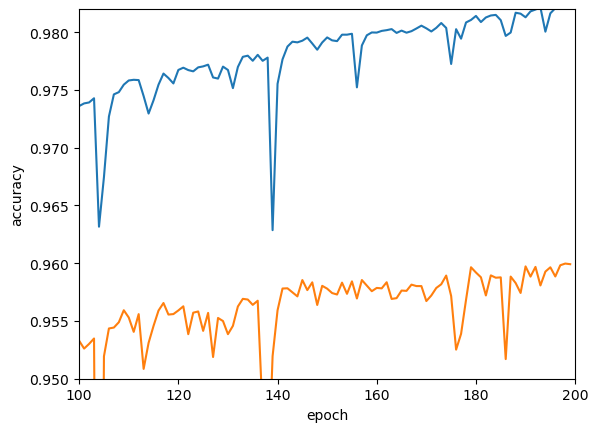

In [104]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.xlim([100,200])
plt.ylim([0.95, 0.982])

In [91]:
model.evaluate(test_dataset)

97/97 [==============================] - 7s 60ms/step - loss: 0.7039 - accuracy: 0.9599


[0.7039300203323364, 0.9599166512489319]

In [105]:
model.save_weights('seg_model')